The notebook selects entries that are considered invalid due feature extraction algorithm problem 

In [1]:
import sys
import os
import subprocess

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import re
# import collections
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
# from tqdm import tqdm
import traceback
import hashlib

from utility_funtions import str2bool_argparse

mpl.rcParams['figure.dpi'] = 80

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
from event_recognition_efficiency_v3 import *
# import supervised_classification as supc

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Welcome to JupyROOT 6.13/02


In [2]:
data_snippents_dir = 'ver3_simu_signal_data_snippets'
os.makedirs(data_snippents_dir, exist_ok=True)

In [3]:
con = con = pg.connect(dbname='eusospb_data', user='eusospb', host='localhost', password='1e20eVjemeuso')
cur = con.cursor()

In [4]:
def get_events_selection_query(source_data_type_num=3, schema_prefix='spb_processing_v3_simu_signal.',
                               select_additional='', join_additional='',where_additional='', 
                               offset=0, limit=100000):
    repldict = dict(schema_prefix=schema_prefix, source_data_type_num=source_data_type_num)
    return '''
SELECT 
    event.event_id, event.config_info_id, event.program_version,
    event.source_file_acquisition, event.source_file_trigger, 
    event.source_file_acquisition_full, event.source_file_trigger_full, 
    event.global_gtu, event.packet_id, event.gtu_in_packet, event.num_gtu, 
    event_trg.count_nonzero AS trg_count_nonzero, 
    event_trg.count_nonzero AS num_triggered_pixels
    
------------------------------------------------------------
    
    {select_additional}
    
 FROM {schema_prefix}event AS event
 JOIN {schema_prefix}event_trg AS event_trg USING(event_id) 
 
 {join_additional}
 
WHERE
    source_data_type_num = {source_data_type_num}
         
    {where_additional}
    
    
OFFSET {offset} LIMIT {limit}
'''.format(**repldict,
           select_additional=select_additional.format(**repldict), 
           join_additional=join_additional.format(**repldict), 
           where_additional=where_additional.format(**repldict),
           offset=offset, limit=limit
          )

# Query parts for ver3

In [5]:
events_selection_query_select_additional__invalid_ver3=''',
    trg_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,
    trg_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,
    
    trg_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_gtu_x_hough_peak_thr2.line_clusters_max_sum_clu_width AS trg_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,
    trg_gtu_x_hough_peak_thr3.line_clusters_max_sum_clu_width AS trg_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,
    
    trg_gtu_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_gtu_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS trg_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,
    trg_gtu_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS trg_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,
    
    trg_x_y_hough_peak_thr1.line_clusters_max_peak_clu_width AS  trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,
    trg_x_y_hough_peak_thr2.line_clusters_max_peak_clu_width AS trg_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,
    trg_x_y_hough_peak_thr3.line_clusters_max_peak_clu_width AS trg_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,
   
    trg_gtu_x_hough_peak_thr1.line_clusters_max_peak_clu_width AS trg_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,
    trg_gtu_x_hough_peak_thr2.line_clusters_max_peak_clu_width AS trg_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,
    trg_gtu_x_hough_peak_thr3.line_clusters_max_peak_clu_width AS trg_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,
   
    trg_gtu_y_hough_peak_thr1.line_clusters_max_peak_clu_width AS trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,
    trg_gtu_y_hough_peak_thr2.line_clusters_max_peak_clu_width AS trg_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,
    trg_gtu_y_hough_peak_thr3.line_clusters_max_peak_clu_width AS trg_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,
       
    --
    
    proc1_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,
    proc1_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,
    proc1_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,
   
    proc1_x_y_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,
    proc1_x_y_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,
    proc1_x_y_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc1_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,
        
    proc1_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,
    proc1_gtu_x_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,
    proc1_gtu_x_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,
    
    proc1_gtu_x_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc1_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,
    proc1_gtu_x_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,
    proc1_gtu_x_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,
   
    proc1_gtu_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,
    proc1_gtu_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,
    proc1_gtu_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,
    
    proc1_gtu_y_hough_peak_thr1.line_clusters_max_peak_clu_width AS proc1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,
    proc1_gtu_y_hough_peak_thr2.line_clusters_max_peak_clu_width AS proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,
    proc1_gtu_y_hough_peak_thr3.line_clusters_max_peak_clu_width AS proc1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width
   
'''

events_selection_query_join_additional__invalid_ver3='''
 LEFT OUTER JOIN {schema_prefix}event_proc1_x_y_hough_peak_thr1 AS proc1_x_y_hough_peak_thr1 USING(event_id) 
 LEFT OUTER JOIN {schema_prefix}event_proc1_x_y_hough_peak_thr2 AS proc1_x_y_hough_peak_thr2 USING(event_id) 
 LEFT OUTER JOIN {schema_prefix}event_proc1_x_y_hough_peak_thr3 AS proc1_x_y_hough_peak_thr3 USING(event_id) 
 LEFT OUTER JOIN {schema_prefix}event_proc1_gtu_x_hough_peak_thr1 AS proc1_gtu_x_hough_peak_thr1 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_proc1_gtu_y_hough_peak_thr1 AS proc1_gtu_y_hough_peak_thr1 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_proc1_gtu_x_hough_peak_thr2 AS proc1_gtu_x_hough_peak_thr2 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_proc1_gtu_y_hough_peak_thr2 AS proc1_gtu_y_hough_peak_thr2 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_proc1_gtu_x_hough_peak_thr3 AS proc1_gtu_x_hough_peak_thr3 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_proc1_gtu_y_hough_peak_thr3 AS proc1_gtu_y_hough_peak_thr3 USING(event_id)
  --- 
 LEFT OUTER JOIN {schema_prefix}event_trg_x_y_hough_peak_thr1 AS trg_x_y_hough_peak_thr1 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_trg_x_y_hough_peak_thr2 AS trg_x_y_hough_peak_thr2 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_trg_x_y_hough_peak_thr3 AS trg_x_y_hough_peak_thr3 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_trg_gtu_x_hough_peak_thr1 AS trg_gtu_x_hough_peak_thr1 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_trg_gtu_x_hough_peak_thr2 AS trg_gtu_x_hough_peak_thr2 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_trg_gtu_x_hough_peak_thr3 AS trg_gtu_x_hough_peak_thr3 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_trg_gtu_y_hough_peak_thr1 AS trg_gtu_y_hough_peak_thr1 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_trg_gtu_y_hough_peak_thr2 AS trg_gtu_y_hough_peak_thr2 USING(event_id)
 LEFT OUTER JOIN {schema_prefix}event_trg_gtu_y_hough_peak_thr3 AS trg_gtu_y_hough_peak_thr3 USING(event_id)
'''

events_selection_query_where_additional__invalid_ver3='''
AND event.program_version=3.0 
AND (
   proc1_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width {cond} {proc_min_val}
OR proc1_x_y_hough_peak_thr1.line_clusters_max_peak_clu_width {cond} {proc_min_val}
--
OR proc1_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width {cond} {proc_min_val}
OR proc1_x_y_hough_peak_thr2.line_clusters_max_peak_clu_width {cond} {proc_min_val}
--
OR proc1_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width {cond} {proc_min_val}
OR proc1_x_y_hough_peak_thr3.line_clusters_max_peak_clu_width {cond} {proc_min_val}
------------------------------------------------------------
OR proc1_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width {cond} {proc_min_val}
OR proc1_gtu_x_hough_peak_thr1.line_clusters_max_peak_clu_width {cond} {proc_min_val}
--
OR proc1_gtu_x_hough_peak_thr2.line_clusters_max_sum_clu_width {cond} {proc_min_val}
OR proc1_gtu_x_hough_peak_thr2.line_clusters_max_peak_clu_width {cond} {proc_min_val}
--
OR proc1_gtu_x_hough_peak_thr3.line_clusters_max_sum_clu_width {cond} {proc_min_val}
OR proc1_gtu_x_hough_peak_thr3.line_clusters_max_peak_clu_width {cond} {proc_min_val}
------------------------------------------------------------
OR proc1_gtu_y_hough_peak_thr1.line_clusters_max_sum_clu_width {cond} {proc_min_val}
OR proc1_gtu_y_hough_peak_thr1.line_clusters_max_peak_clu_width {cond} {proc_min_val}
--
OR proc1_gtu_y_hough_peak_thr2.line_clusters_max_sum_clu_width {cond} {proc_min_val}
OR proc1_gtu_y_hough_peak_thr2.line_clusters_max_peak_clu_width {cond} {proc_min_val}
--
OR proc1_gtu_y_hough_peak_thr3.line_clusters_max_sum_clu_width {cond} {proc_min_val}
OR proc1_gtu_y_hough_peak_thr3.line_clusters_max_peak_clu_width {cond} {proc_min_val}
------------------------------------------------------------
OR trg_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width {cond} {trg_proc_min_val}
OR trg_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width {cond} {trg_proc_min_val}
OR trg_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width {cond} {trg_proc_min_val}
--
OR trg_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width {cond} {trg_proc_min_val}
OR trg_gtu_x_hough_peak_thr2.line_clusters_max_sum_clu_width {cond} {trg_proc_min_val}
OR trg_gtu_x_hough_peak_thr3.line_clusters_max_sum_clu_width {cond} {trg_proc_min_val}
--
OR trg_gtu_y_hough_peak_thr1.line_clusters_max_sum_clu_width {cond} {trg_proc_min_val}
OR trg_gtu_y_hough_peak_thr2.line_clusters_max_sum_clu_width {cond} {trg_proc_min_val}
OR trg_gtu_y_hough_peak_thr3.line_clusters_max_sum_clu_width {cond} {trg_proc_min_val}
--
OR trg_x_y_hough_peak_thr1.line_clusters_max_peak_clu_width {cond} {trg_proc_min_val}
OR trg_x_y_hough_peak_thr2.line_clusters_max_peak_clu_width {cond} {trg_proc_min_val}
OR trg_x_y_hough_peak_thr3.line_clusters_max_peak_clu_width {cond} {trg_proc_min_val}
--
OR trg_gtu_x_hough_peak_thr1.line_clusters_max_peak_clu_width {cond} {trg_proc_min_val}
OR trg_gtu_x_hough_peak_thr2.line_clusters_max_peak_clu_width {cond} {trg_proc_min_val}
OR trg_gtu_x_hough_peak_thr3.line_clusters_max_peak_clu_width {cond} {trg_proc_min_val}
--
OR trg_gtu_y_hough_peak_thr1.line_clusters_max_peak_clu_width {cond} {trg_proc_min_val}
OR trg_gtu_y_hough_peak_thr2.line_clusters_max_peak_clu_width {cond} {trg_proc_min_val}
OR trg_gtu_y_hough_peak_thr3.line_clusters_max_peak_clu_width {cond} {trg_proc_min_val}
)

ORDER BY proc1_gtu_y_hough_peak_thr3.line_clusters_max_peak_clu_width ASC
    '''.format(cond='=', proc_min_val=179, trg_proc_min_val=89, alt_proc_min_val=179)

# Simu signal patricia bgf0.5

In [6]:
events_selection_query__simu_patricia__invalid = get_events_selection_query(
    source_data_type_num=10001, 
    select_additional=events_selection_query_select_additional__invalid_ver3,
    join_additional=events_selection_query_join_additional__invalid_ver3,
    where_additional=events_selection_query_where_additional__invalid_ver3
)
print(events_selection_query__simu_patricia__invalid)


SELECT 
    event.event_id, event.config_info_id, event.program_version,
    event.source_file_acquisition, event.source_file_trigger, 
    event.source_file_acquisition_full, event.source_file_trigger_full, 
    event.global_gtu, event.packet_id, event.gtu_in_packet, event.num_gtu, 
    event_trg.count_nonzero AS trg_count_nonzero, 
    event_trg.count_nonzero AS num_triggered_pixels
    
------------------------------------------------------------
    
    ,
    trg_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,
    trg_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,
    
    trg_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_gtu_x_hough_peak_thr2.line_clusters_m

In [7]:
simu_patricia_events_df = psql.read_sql(events_selection_query__simu_patricia__invalid, con) 

In [8]:
len(simu_patricia_events_df)

12227

In [9]:
p = os.path.join(data_snippents_dir,'ver3_simu_signal_invalid_{}.tsv'.format('simu_signal_patricia'))
simu_patricia_events_df[['source_file_acquisition_full','global_gtu']].to_csv(p,sep='\t', header=False,index=False)
print(os.path.realpath(p))

/home/vrabel/EUSO-Balloon/vrabel/notebooks/ver3_simu_signal_data_snippets/ver3_simu_signal_invalid_simu_signal_patricia.tsv


In [10]:
#events_df.to_csv(os.path.join(data_snippents_dir,'visible_events.csv'))

In [11]:
# for k,v in simu05_events_df.iloc[1].iteritems():
#     print("{}\t{}".format(k,v))

In [12]:
events_to_vis_df = simu_patricia_events_df.iloc[:]

In [13]:
pd.set_option('display.max_columns', 100)
events_to_vis_df

,event_id,config_info_id,program_version,source_file_acquisition,source_file_trigger,source_file_acquisition_full,source_file_trigger_full,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_count_nonzero,num_triggered_pixels,trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width
0,43920,1,3.0,posz_21000000.00/energy_7.94e+12/thousnd21E18....,None,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,None,30,0,30,38,22,22,15.0,12.0,89.0,14.0,3.0,1.0,85.0,2.0,2.0,4.0,12.0,89.0,14.0,3.0,1.0,85.0,2.0,2.0,18,6,178,18,6,178,57.0,8.0,2.0,57.0,10.0,2.0,10,8,1,10,8,1
1,26212,1,3.0,posz_33000000.00/energy_4.47e+12/thousnd33E13....,None,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,None,30,0,30,38,10,10,89.0,88.0,2.0,22.0,14.0,5.0,73.0,73.0,9.0,89.0,88.0,2.0,1.0,14.0,5.0,73.0,73.0,3.0,178,51,4,178,51,4,74.0,17.0,2.0,74.0,17.0,2.0,23,23,1,23,23,1
2,69051,1,3.0,posz_24000000.00/energy_6.85e+12/simu.2017-07-...,None,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,None,30,0,30,38,19,19,89.0,35.0,2.0,29.0,5.0,1.0,34.0,11.0,11.0,89.0,1.0,2.0,1.0,5.0,1.0,1.0,11.0,11.0,13,5,5,13,1,1,31.0,31.0,2.0,7.0,7.0,2.0,3,3,1,3,3,1
3,4397,1,3.0,posz_24000000.00/energy_1.00e+13/para.2017-07-...,None,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,None,30,0,30,38,6,6,89.0,22.0,22.0,16.0,16.0,16.0,33.0,33.0,33.0,19.0,22.0,22.0,3.0,3.0,3.0,3.0,3.0,3.0,27,27,27,17,17,17,5.0,5.0,5.0,5.0,5.0,5.0,1,1,1,1,1,1
4,4402,1,3.0,posz_30000000.00/energy_1.12e+12/thousnd30E1.2...,None,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,None,30,0,30,38,19,19,89.0,53.0,12.0,15.0,9.0,7.0,85.0,7.0,1.0,89.0,53.0,12.0,15.0,9.0,7.0,85.0,7.0,1.0,105,71,1,19,71,1,41.0,34.0,14.0,41.0,34.0,14.0,117,103,17,117,103,1
5,75581,1,3.0,posz_24000000.00/energy_8.91e+12/thousnd24E19....,None,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,None,30,0,30,38,52,52,84.0,26.0,4.0,22.0,20.0,1.0,36.0,88.0,89.0,84.0,2.0,1.0,22.0,20.0,1.0,1.0,88.0,89.0,52,7,2,52,1,2,15.0,10.0,1.0,1

len(event_frames)=25 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=25 event_frames_offset=0
len(event_frames)=19 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=19 event_frames_offset=0
len(event_frames)=26 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=26 event_frames_offset=0
len(event_frames)=20 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=20 event_frames_offset=0
len(event_frames)=24 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=24 event_frames_offset=0
len(event_frames)=31 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=31 event_frames_offset=0
len(event_frames)=16 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 eve

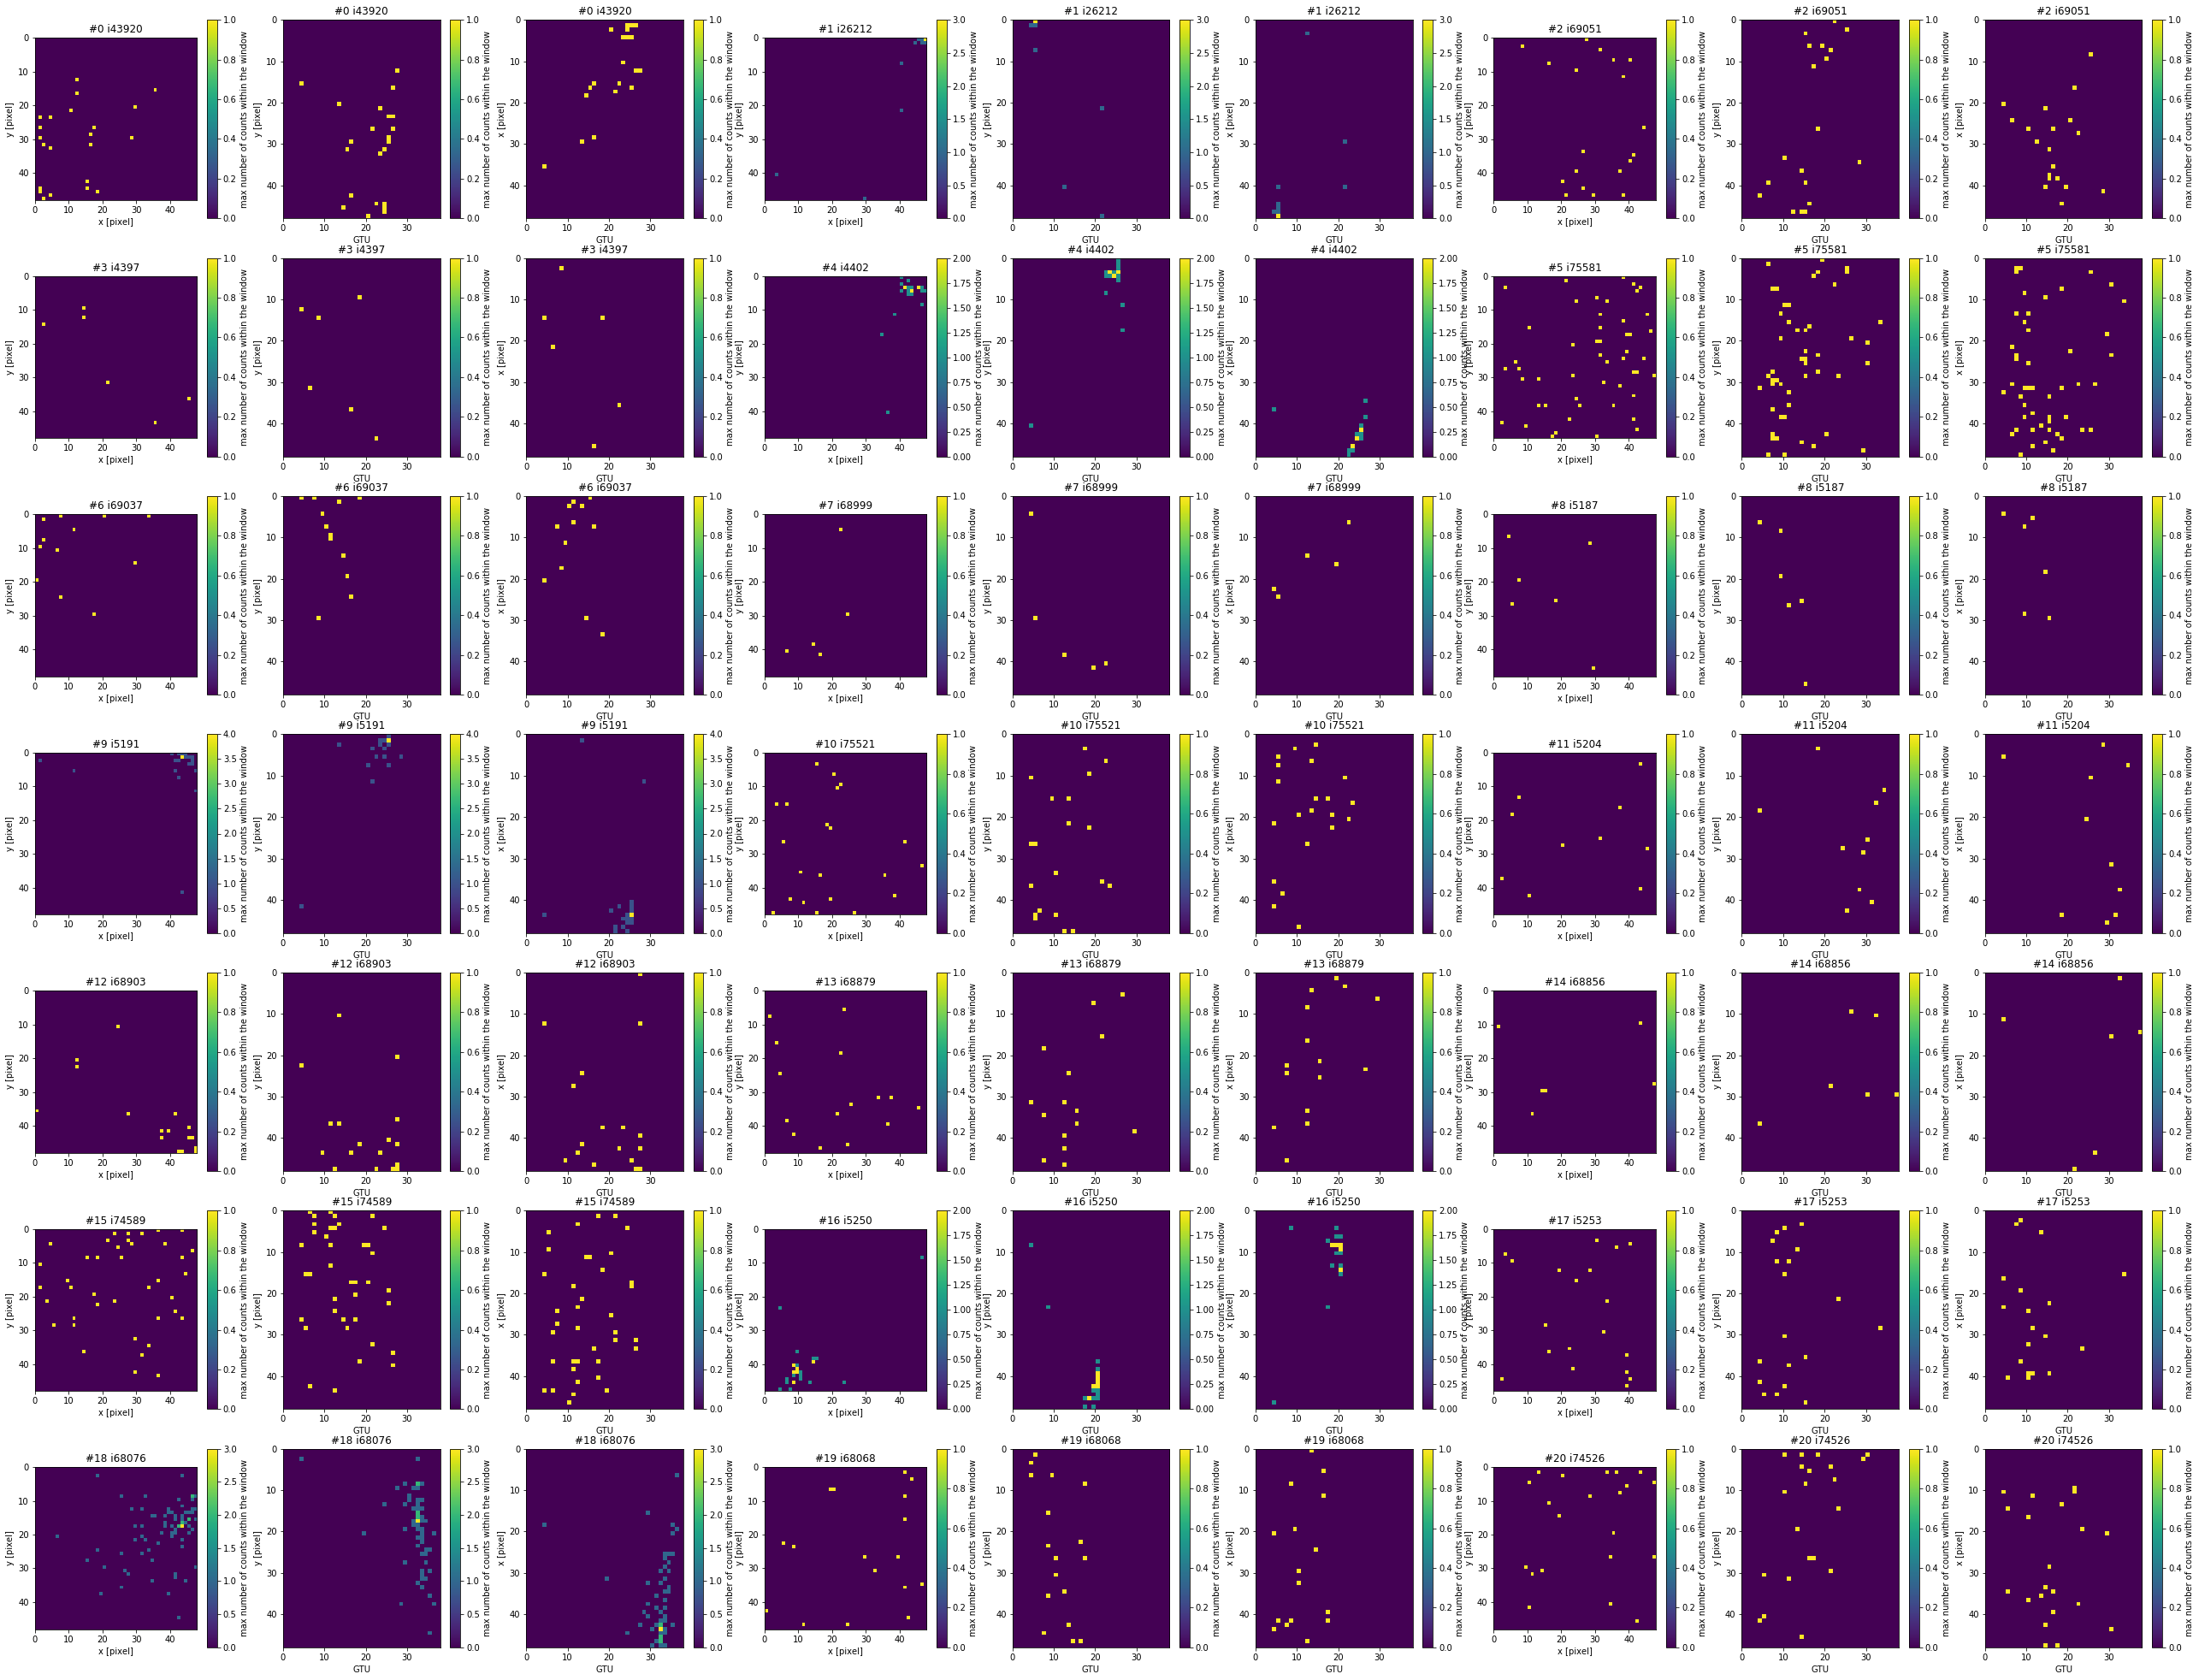

In [14]:
plt.close('all')

fig, axs = plt.subplots(7, 9)
fig.set_size_inches(9*5,7*5)
axs_flattened = axs.flatten()
ai = 0

for i,(rid,r) in enumerate(events_to_vis_df.iterrows()):
    simu_gtu_start = r['gtu_in_packet']-4-30
    simu_gtu_end = simu_gtu_start+r['num_gtu']
    
    if ai+2 >= len(axs_flattened):
        break

    visualize_simu_event_projections(r['source_file_acquisition_full'], 
                                     title="#{} i{}".format(i, r['event_id']), 
                                     axs_flattened=axs_flattened, 
                                     vis_xy=True, vis_gtux=True, vis_gtuy=True, ai=ai,
                                     gtu_range=(simu_gtu_start, simu_gtu_end),
                                     get_simunpy_func=lambda x:x)
    ai += 3
    
    if ai >= len(axs_flattened):
        break

    
plt.show()

# Simu kenji rms0 0.5

In [15]:
events_selection_query__simukenjirms005__invalid = get_events_selection_query(
    source_data_type_num=10002, 
    select_additional=events_selection_query_select_additional__invalid_ver3,
    join_additional=events_selection_query_join_additional__invalid_ver3,
    where_additional=events_selection_query_where_additional__invalid_ver3
)
print(events_selection_query__simukenjirms005__invalid)


SELECT 
    event.event_id, event.config_info_id, event.program_version,
    event.source_file_acquisition, event.source_file_trigger, 
    event.source_file_acquisition_full, event.source_file_trigger_full, 
    event.global_gtu, event.packet_id, event.gtu_in_packet, event.num_gtu, 
    event_trg.count_nonzero AS trg_count_nonzero, 
    event_trg.count_nonzero AS num_triggered_pixels
    
------------------------------------------------------------
    
    ,
    trg_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,
    trg_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,
    
    trg_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_gtu_x_hough_peak_thr2.line_clusters_m

In [16]:
simukenjirms005_events_df = psql.read_sql(events_selection_query__simukenjirms005__invalid, con) 

In [17]:
len(simukenjirms005_events_df)

3222

In [18]:
simukenjirms005_events_df[['source_file_acquisition_full','global_gtu']].to_csv(os.path.join(
    data_snippents_dir,'ver3_simu_signal_invalid_{}.tsv'.format('simukenjirms005_events_df')),sep='\t',
                        header=False,index=False)

In [19]:
events_to_vis_df = simukenjirms005_events_df.iloc[:]

In [20]:
pd.set_option('display.max_columns', 100)
events_to_vis_df

,event_id,config_info_id,program_version,source_file_acquisition,source_file_trigger,source_file_acquisition_full,source_file_trigger_full,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_count_nonzero,num_triggered_pixels,trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width
0,107763,1,3.0,spbx100rms0mm/posz_16500000.00/energy_6.41e+11...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,3,3,89.0,89.0,89.0,43.0,43.0,43.0,43.0,24.0,24.0,89.0,89.0,89.0,1.0,1.0,1.0,1.0,24.0,24.0,29,12,7,14,12,7,72,52,4,72,52,4,28,21,1,1,21,1
1,107750,1,3.0,spbx100rms0mm/posz_16500000.00/energy_6.41e+11...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,11,11,9.0,6.0,4.0,4.0,89.0,1.0,16.0,8.0,5.0,9.0,6.0,4.0,4.0,89.0,1.0,16.0,8.0,5.0,14,10,9,14,10,9,5,5,4,5,5,4,32,178,6,32,178,1
2,107654,1,3.0,spbx100rms0mm/posz_16500000.00/energy_6.41e+11...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,32,32,84.0,17.0,1.0,26.0,8.0,89.0,19.0,5.0,1.0,84.0,1.0,1.0,26.0,8.0,89.0,1.0,5.0,1.0,34,8,1,1,8,1,6,6,1,6,6,1,5,2,1,2,1,1
3,103374,1,3.0,spbx100rms0mm/posz_16500000.00/energy_4.28e+11...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,79,79,89.0,41.0,4.0,6.0,89.0,1.0,4.0,89.0,1.0,89.0,5.0,1.0,6.0,89.0,1.0,4.0,89.0,1.0,82,66,2,19,5,1,6,4,1,6,4,1,5,3,1,5,3,1
4,80862,1,3.0,spbx100rms0mm/posz_16500000.00/energy_2.61e+11...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,16,16,89.0,53.0,21.0,16.0,13.0,8.0,14.0,9.0,1.0,89.0,53.0,1.0,16.0,13.0,8.0,14.0,9.0,1.0,168,114,25,168,1,13,30,20,1,30,20,1,21,20,1,21,20,1
5,103421,1,3.0,spbx100rms0mm/posz_16500000.00/energy_4.34e+11...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,10,10,12.0,12.0,4.0,88.0,2.0,1.0,89.0,89.0,2.0,12.0,12.0,4.0,88.0,2.0,1.0,89.0,89.0,2.0,26,8,8,26,8,8,8,5,5,8,5,5,5,5,1,5,5,1
6,103423,1,3.0,spbx100rms0mm/posz_16500000.00/energy_4.34e+11...,No

len(event_frames)=14 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=14 event_frames_offset=0
len(event_frames)=12 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=12 event_frames_offset=0
len(event_frames)=18 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=18 event_frames_offset=0
len(event_frames)=30 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=30 event_frames_offset=0
len(event_frames)=5 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=5 event_frames_offset=0
len(event_frames)=4 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=4 event_frames_offset=0
len(event_frames)=5 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_fr

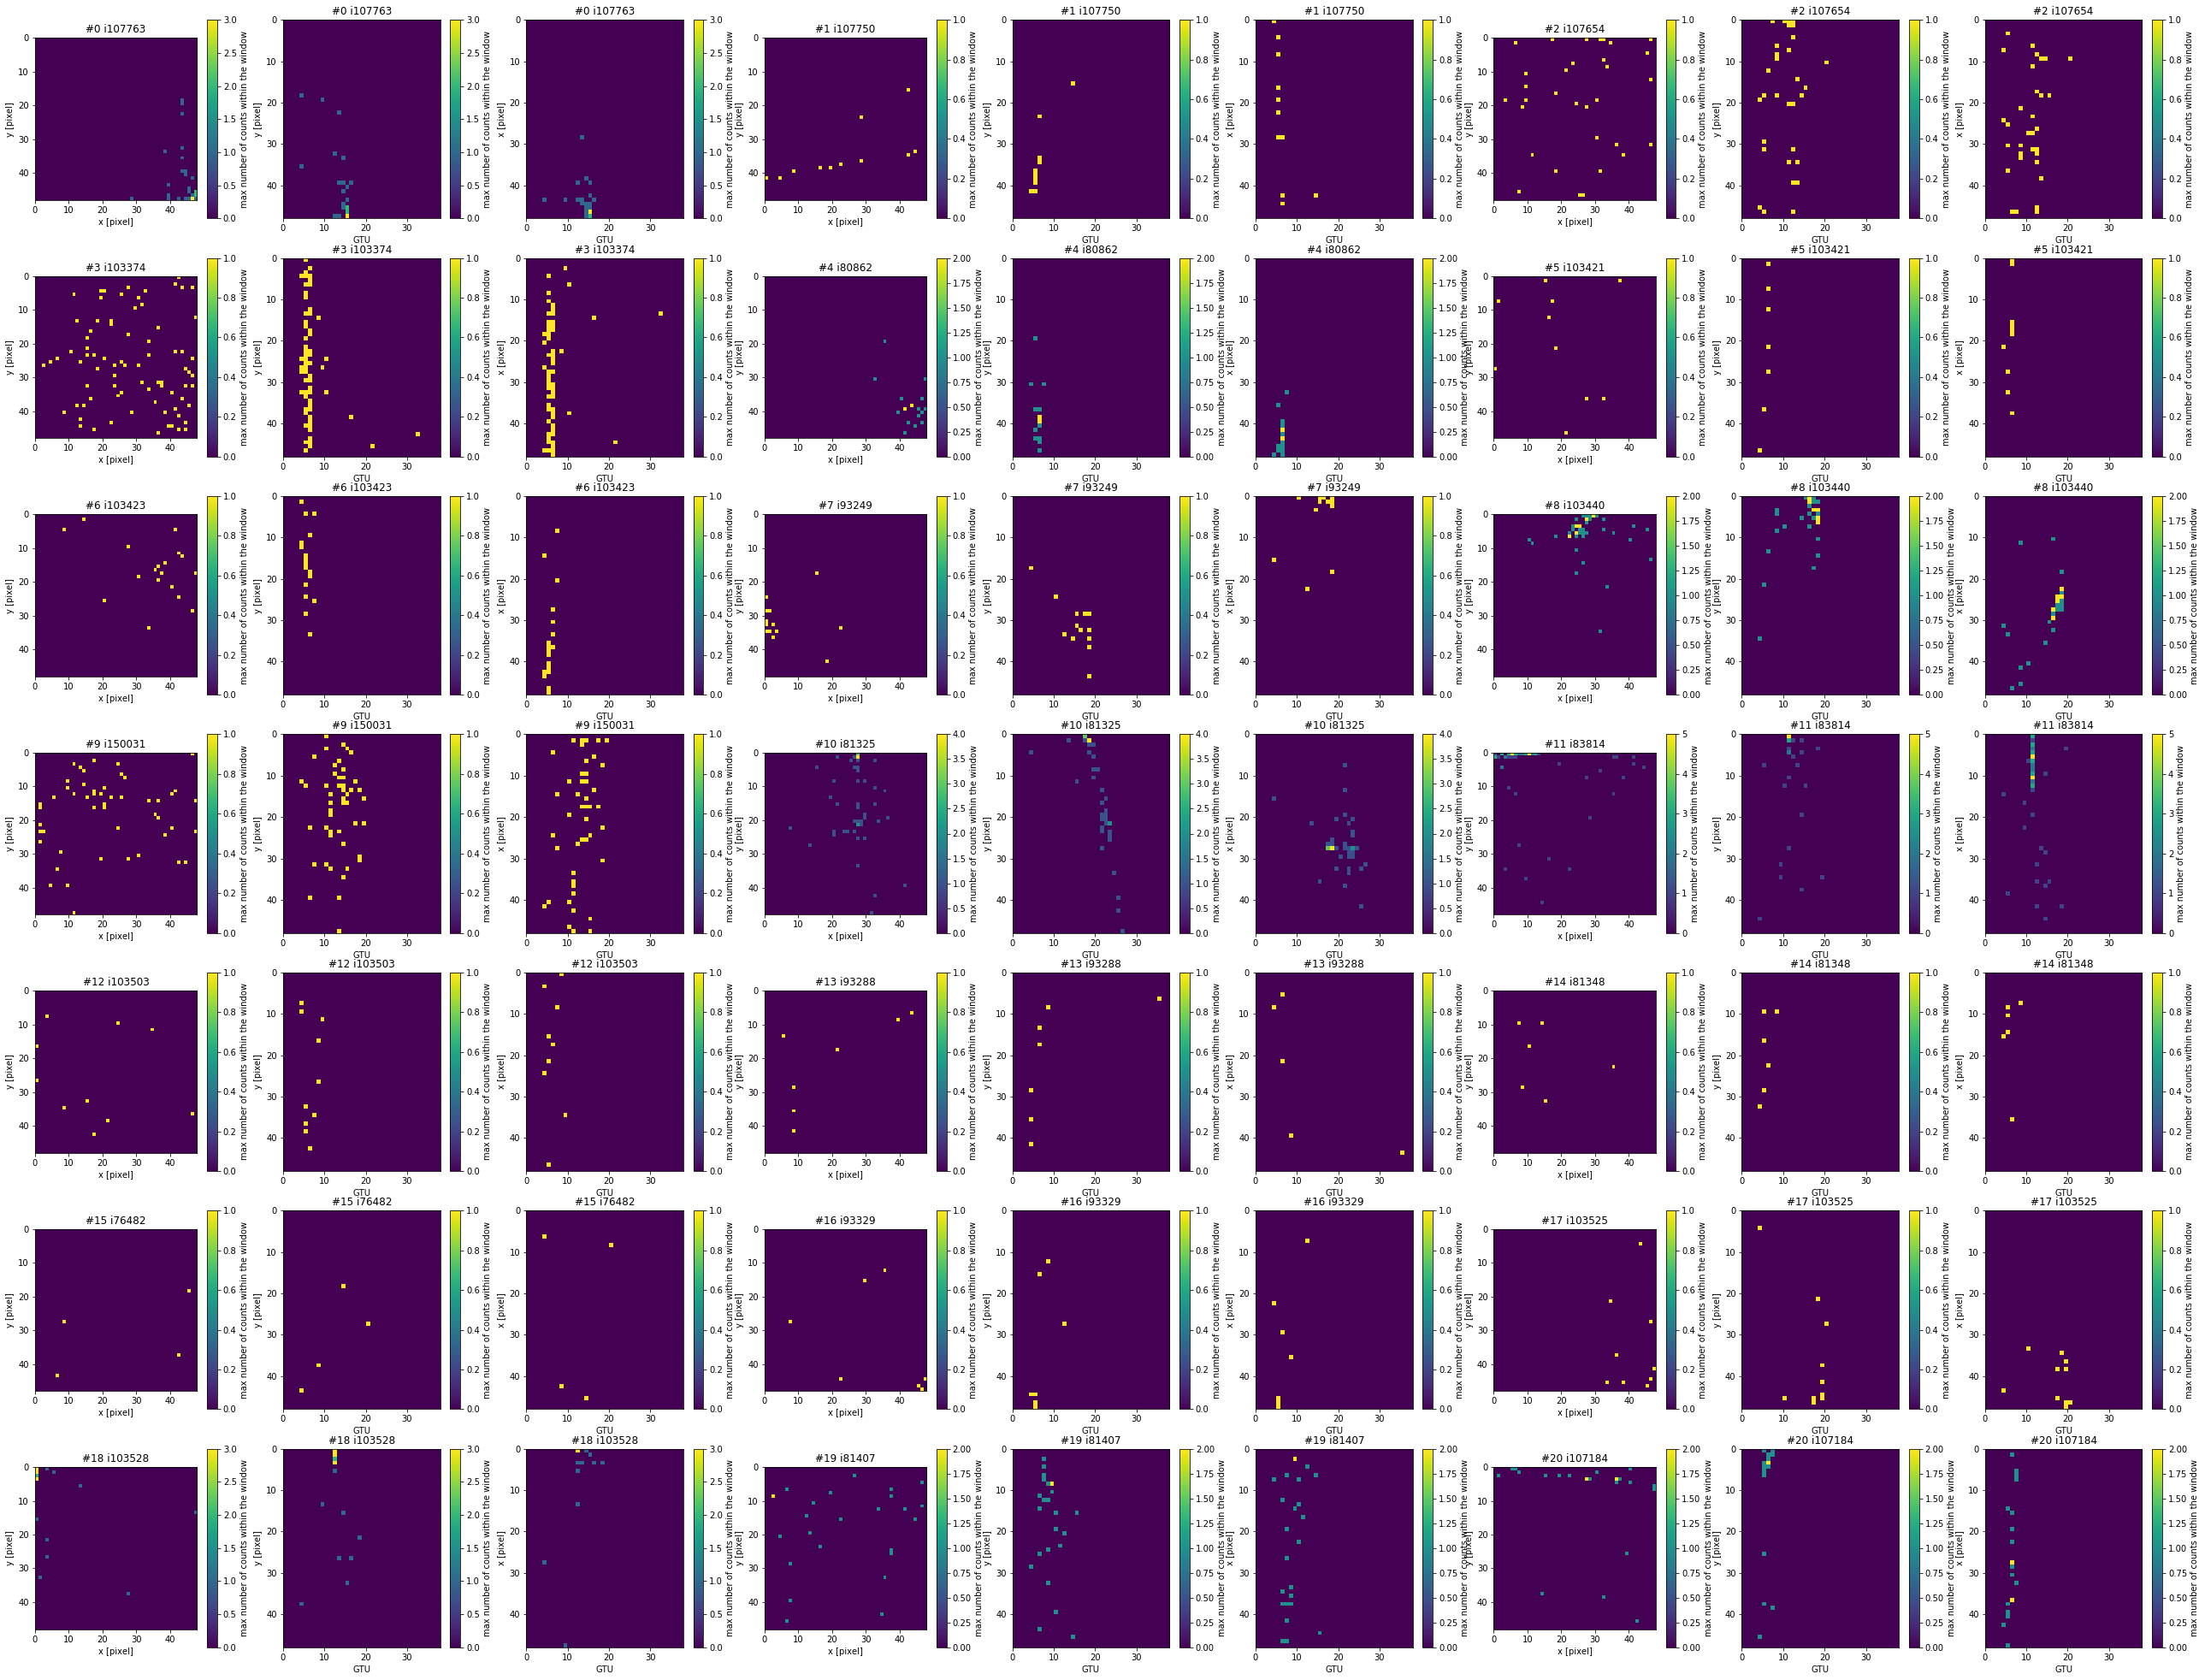

In [21]:
plt.close('all')

fig, axs = plt.subplots(7, 9)
fig.set_size_inches(9*5,7*5)
axs_flattened = axs.flatten()
ai = 0

for i,(rid,r) in enumerate(events_to_vis_df.iterrows()):
    simu_gtu_start = r['gtu_in_packet']-4-30
    simu_gtu_end = simu_gtu_start+r['num_gtu']
    
    if ai+2 >= len(axs_flattened):
        break

    visualize_simu_event_projections(r['source_file_acquisition_full'], 
                                     title="#{} i{}".format(i, r['event_id']), 
                                     axs_flattened=axs_flattened, 
                                     vis_xy=True, vis_gtux=True, vis_gtuy=True, ai=ai,
                                     gtu_range=(simu_gtu_start, simu_gtu_end),
                                     get_simunpy_func=lambda x:x)
    ai += 3
    
    if ai >= len(axs_flattened):
        break

    
plt.show()

# Simu kenji rms5 bgf 0.5

In [22]:
events_selection_query__simukenjirms505__invalid = get_events_selection_query(
    source_data_type_num=10003, 
    select_additional=events_selection_query_select_additional__invalid_ver3,
    join_additional=events_selection_query_join_additional__invalid_ver3,
    where_additional=events_selection_query_where_additional__invalid_ver3
)
print(events_selection_query__simukenjirms505__invalid)


SELECT 
    event.event_id, event.config_info_id, event.program_version,
    event.source_file_acquisition, event.source_file_trigger, 
    event.source_file_acquisition_full, event.source_file_trigger_full, 
    event.global_gtu, event.packet_id, event.gtu_in_packet, event.num_gtu, 
    event_trg.count_nonzero AS trg_count_nonzero, 
    event_trg.count_nonzero AS num_triggered_pixels
    
------------------------------------------------------------
    
    ,
    trg_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,
    trg_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,
    
    trg_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_gtu_x_hough_peak_thr2.line_clusters_m

In [23]:
simukenjirms505_events_df = psql.read_sql(events_selection_query__simukenjirms505__invalid, con) 

In [24]:
len(simukenjirms505_events_df)

9894

In [25]:
simukenjirms505_events_df[['source_file_acquisition_full','global_gtu']].to_csv(
    os.path.join(data_snippents_dir,'ver3_simu_signal_invalid_{}.tsv'.format('simukenjirms505_events_df')),sep='\t',
                        header=False,index=False)

In [26]:
events_to_vis_df = simukenjirms505_events_df.iloc[:]

In [27]:
pd.set_option('display.max_columns', 100)
events_to_vis_df

,event_id,config_info_id,program_version,source_file_acquisition,source_file_trigger,source_file_acquisition_full,source_file_trigger_full,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_count_nonzero,num_triggered_pixels,trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width
0,116916,1,3.0,spbx100rms5mm/posz_16500000.00/energy_3.22e+11...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,19,19,59.0,11.0,5.0,87.0,3.0,3.0,7.0,5.0,1.0,4.0,1.0,5.0,87.0,3.0,3.0,7.0,5.0,1.0,22,22,9,22,22,9,20,16,179,20,16,179,14,11,1,14,11,1
1,113209,1,3.0,spbx100rms5mm/posz_33000000.00/energy_4.39e+12...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,5,5,89.0,21.0,11.0,83.0,26.0,26.0,36.0,36.0,21.0,89.0,21.0,11.0,83.0,26.0,26.0,36.0,36.0,21.0,29,22,179,29,22,179,46,25,7,46,1,7,13,6,1,13,6,1
2,91446,1,3.0,spbx100rms5mm/posz_33000000.00/energy_1.20e+12...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,3,3,89.0,89.0,89.0,65.0,65.0,65.0,48.0,18.0,18.0,89.0,89.0,89.0,65.0,65.0,65.0,9.0,18.0,18.0,102,43,8,5,43,8,14,9,1,14,9,1,28,18,1,1,18,1
3,161118,1,3.0,spbx100rms5mm/posz_16500000.00/energy_7.22e+11...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,60,60,24.0,15.0,4.0,10.0,89.0,3.0,26.0,16.0,89.0,24.0,15.0,4.0,10.0,89.0,3.0,26.0,16.0,2.0,25,13,1,25,13,1,12,7,3,12,7,3,32,27,1,32,27,1
4,91455,1,3.0,spbx100rms5mm/posz_16500000.00/energy_2.61e+11...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,24,24,86.0,14.0,3.0,7.0,88.0,5.0,21.0,89.0,2.0,86.0,5.0,3.0,7.0,88.0,5.0,3.0,89.0,2.0,9,9,5,9,9,5,11,176,2,11,176,2,8,6,1,8,6,1
5,161117,1,3.0,spbx100rms5mm/posz_16500000.00/energy_7.22e+11...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,23,23,82.0,11.0,2.0,6.0,89.0,1.0,11.0,88.0,2.0,1.0,3.0,2.0,6.0,89.0,1.0,11.0,88.0,2.0,22,22,9,1,1,9,10,7,179,10,7,179,10,4,1,10,4,1
6,119910,1,3.0,spbx100rms5mm/posz_1

len(event_frames)=12 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=12 event_frames_offset=0
len(event_frames)=24 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=24 event_frames_offset=0
len(event_frames)=42 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=34 event_frames_offset=0
len(event_frames)=14 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=14 event_frames_offset=0
len(event_frames)=33 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=33 event_frames_offset=0
len(event_frames)=17 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=17 event_frames_offset=0
len(event_frames)=12 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 eve

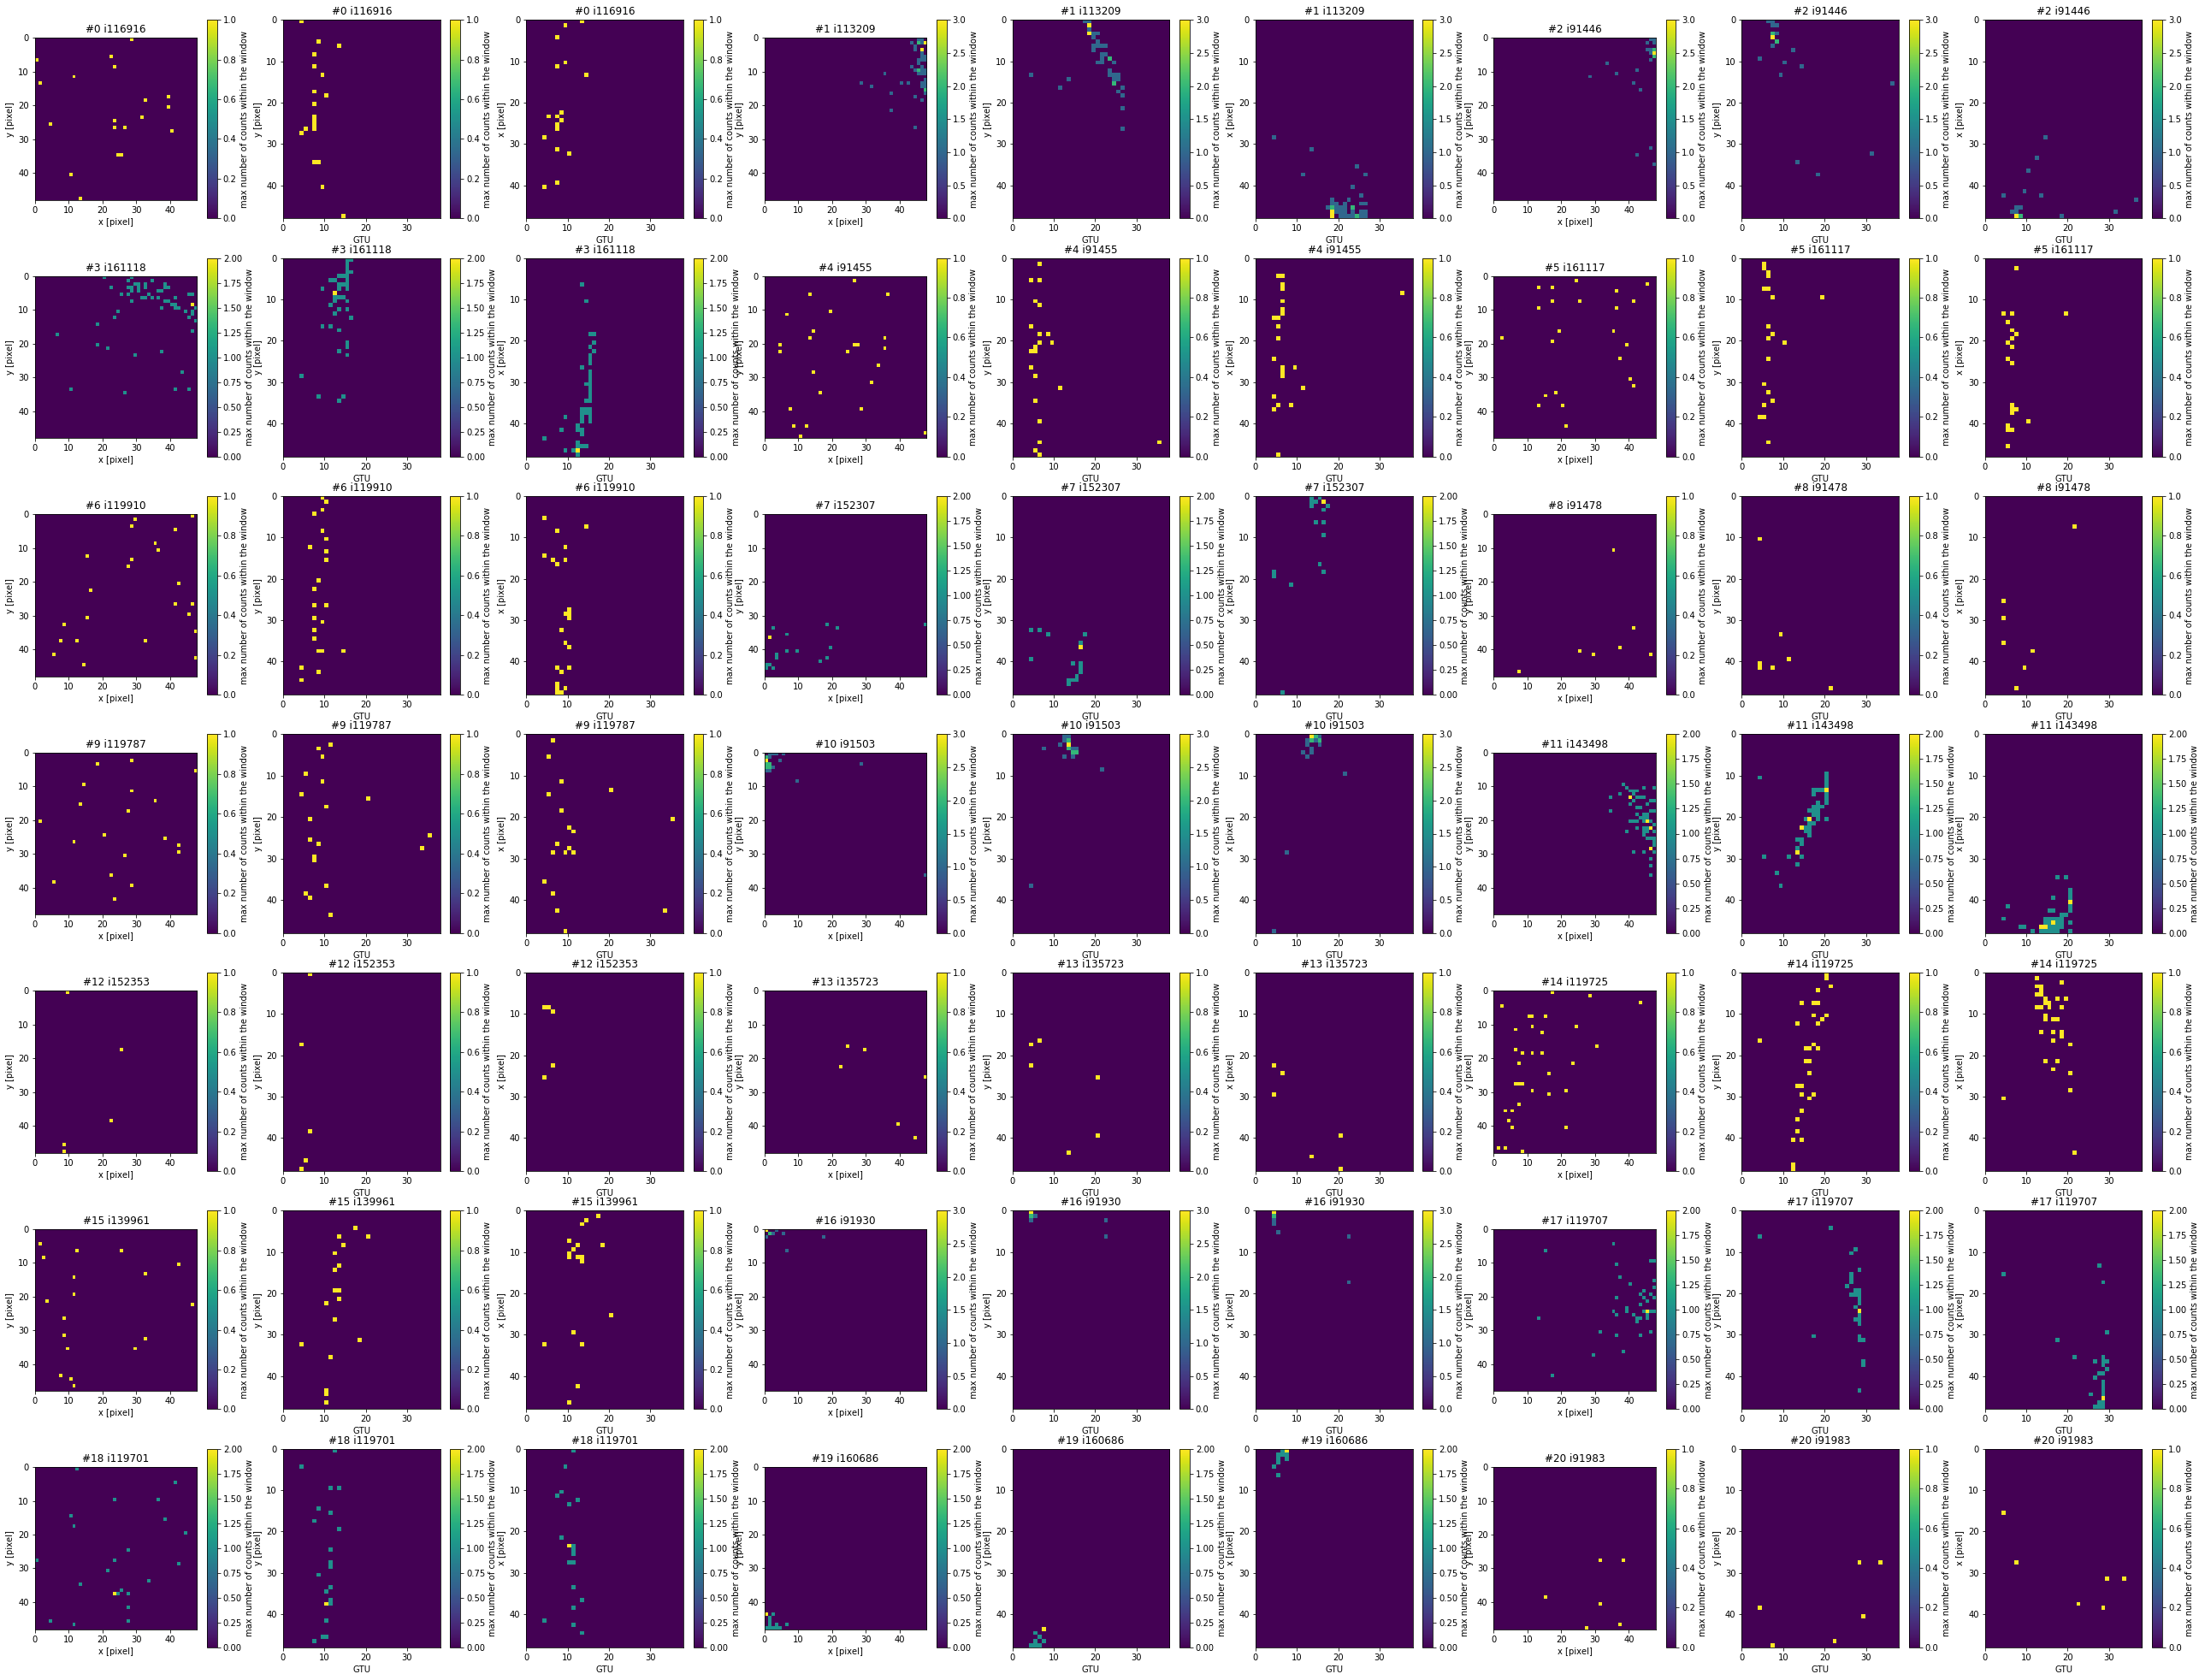

In [28]:
plt.close('all')

fig, axs = plt.subplots(7, 9)
fig.set_size_inches(9*5,7*5)
axs_flattened = axs.flatten()
ai = 0

for i,(rid,r) in enumerate(events_to_vis_df.iterrows()):
    simu_gtu_start = r['gtu_in_packet']-4-30
    simu_gtu_end = simu_gtu_start+r['num_gtu']
    
    if ai+2 >= len(axs_flattened):
        break

    visualize_simu_event_projections(r['source_file_acquisition_full'], 
                                     title="#{} i{}".format(i, r['event_id']), 
                                     axs_flattened=axs_flattened, 
                                     vis_xy=True, vis_gtux=True, vis_gtuy=True, ai=ai,
                                     gtu_range=(simu_gtu_start, simu_gtu_end),
                                     get_simunpy_func=lambda x:x)
    ai += 3
    
    if ai >= len(axs_flattened):
        break

    
plt.show()

# Simu kenji slope1.5 bgf 0.5

In [29]:
events_selection_query__simukenjislope1505__invalid = get_events_selection_query(
    source_data_type_num=10004, 
    select_additional=events_selection_query_select_additional__invalid_ver3,
    join_additional=events_selection_query_join_additional__invalid_ver3,
    where_additional=events_selection_query_where_additional__invalid_ver3
)
print(events_selection_query__simukenjislope1505__invalid)


SELECT 
    event.event_id, event.config_info_id, event.program_version,
    event.source_file_acquisition, event.source_file_trigger, 
    event.source_file_acquisition_full, event.source_file_trigger_full, 
    event.global_gtu, event.packet_id, event.gtu_in_packet, event.num_gtu, 
    event_trg.count_nonzero AS trg_count_nonzero, 
    event_trg.count_nonzero AS num_triggered_pixels
    
------------------------------------------------------------
    
    ,
    trg_x_y_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_x_y_hough_peak_thr2.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,
    trg_x_y_hough_peak_thr3.line_clusters_max_sum_clu_width AS trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,
    
    trg_gtu_x_hough_peak_thr1.line_clusters_max_sum_clu_width AS trg_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,
    trg_gtu_x_hough_peak_thr2.line_clusters_m

In [30]:
simukenjislope1505_events_df = psql.read_sql(events_selection_query__simukenjislope1505__invalid, con) 

In [31]:
len(simukenjislope1505_events_df)

4324

In [32]:
simukenjislope1505_events_df[['source_file_acquisition_full','global_gtu']].to_csv(
    os.path.join(data_snippents_dir,'ver3_simu_signal_invalid_{}.tsv'.format('simukenjislope1505_events_df')),sep='\t',
                        header=False,index=False)

In [33]:
events_to_vis_df = simukenjislope1505_events_df.iloc[:]

In [34]:
pd.set_option('display.max_columns', 100)
events_to_vis_df

,event_id,config_info_id,program_version,source_file_acquisition,source_file_trigger,source_file_acquisition_full,source_file_trigger_full,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_count_nonzero,num_triggered_pixels,trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width
0,116415,1,3.0,slope1.5/posz_24750000.00/energy_3.54e+11/SPB_...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,63,63,89,87,53,53.0,17.0,2.0,83.0,14.0,1.0,89,87,53,53.0,17.0,2.0,83.0,14.0,1.0,177,131,14,177,131,14,112,99,11,112,99,3,51.0,40.0,1.0,51.0,40.0,1.0
1,139883,1,3.0,slope1.5/posz_24750000.00/energy_6.72e+11/SPB0...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,4,4,89,24,24,39.0,2.0,2.0,38.0,38.0,38.0,89,11,11,39.0,2.0,2.0,7.0,7.0,7.0,54,54,54,22,22,22,47,47,47,20,20,20,7.0,7.0,7.0,1.0,1.0,1.0
2,96656,1,3.0,slope1.5/posz_24750000.00/energy_1.62e+12/SPB0...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,17,17,35,35,11,14.0,2.0,2.0,22.0,22.0,89.0,35,35,11,14.0,2.0,2.0,22.0,22.0,89.0,74,15,15,50,8,8,27,27,174,27,27,174,24.0,24.0,1.0,24.0,24.0,1.0
3,139850,1,3.0,slope1.5/posz_24750000.00/energy_6.72e+11/SPB0...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,5,5,89,26,26,17.0,1.0,1.0,60.0,15.0,15.0,89,26,26,6.0,1.0,1.0,60.0,15.0,15.0,53,53,53,53,53,53,12,12,12,12,12,12,1.0,1.0,1.0,1.0,1.0,1.0
4,139369,1,3.0,slope1.5/posz_24750000.00/energy_6.40e+11/SPB0...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,82,82,53,17,9,26.0,88.0,4.0,12.0,10.0,6.0,53,17,9,1.0,88.0,4.0,12.0,10.0,6.0,39,20,13,39,20,13,179,178,23,179,178,23,11.0,8.0,1.0,11.0,8.0,1.0
5,96804,1,3.0,slope1.5/posz_24750000.00/energy_1.62e+12/SPB_...,None,/home/spbproc/SPBDATA_processed/spb_simu_kenji...,None,30,0,30,38,50,50,21,12,5,89.0,89.0,2.0,32.0,9.0,4.0,21,12,5,89.0,89.0,2.0,32.0,9.0,4.0,22,18,1,22,18,1,14,178,179,14,178,179,51.0,27.0,1.0,51.0,27.0,1

len(event_frames)=29 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=29 event_frames_offset=0
len(event_frames)=6 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=6 event_frames_offset=0
len(event_frames)=12 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=12 event_frames_offset=0
len(event_frames)=9 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=9 event_frames_offset=0
len(event_frames)=25 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=25 event_frames_offset=0
len(event_frames)=31 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_frames_sec_len=31 event_frames_offset=0
len(event_frames)=9 n_event_frames_count=38 n_event_frames.shape=(38, 48, 48) n_event_frames_offset=4 event_fr

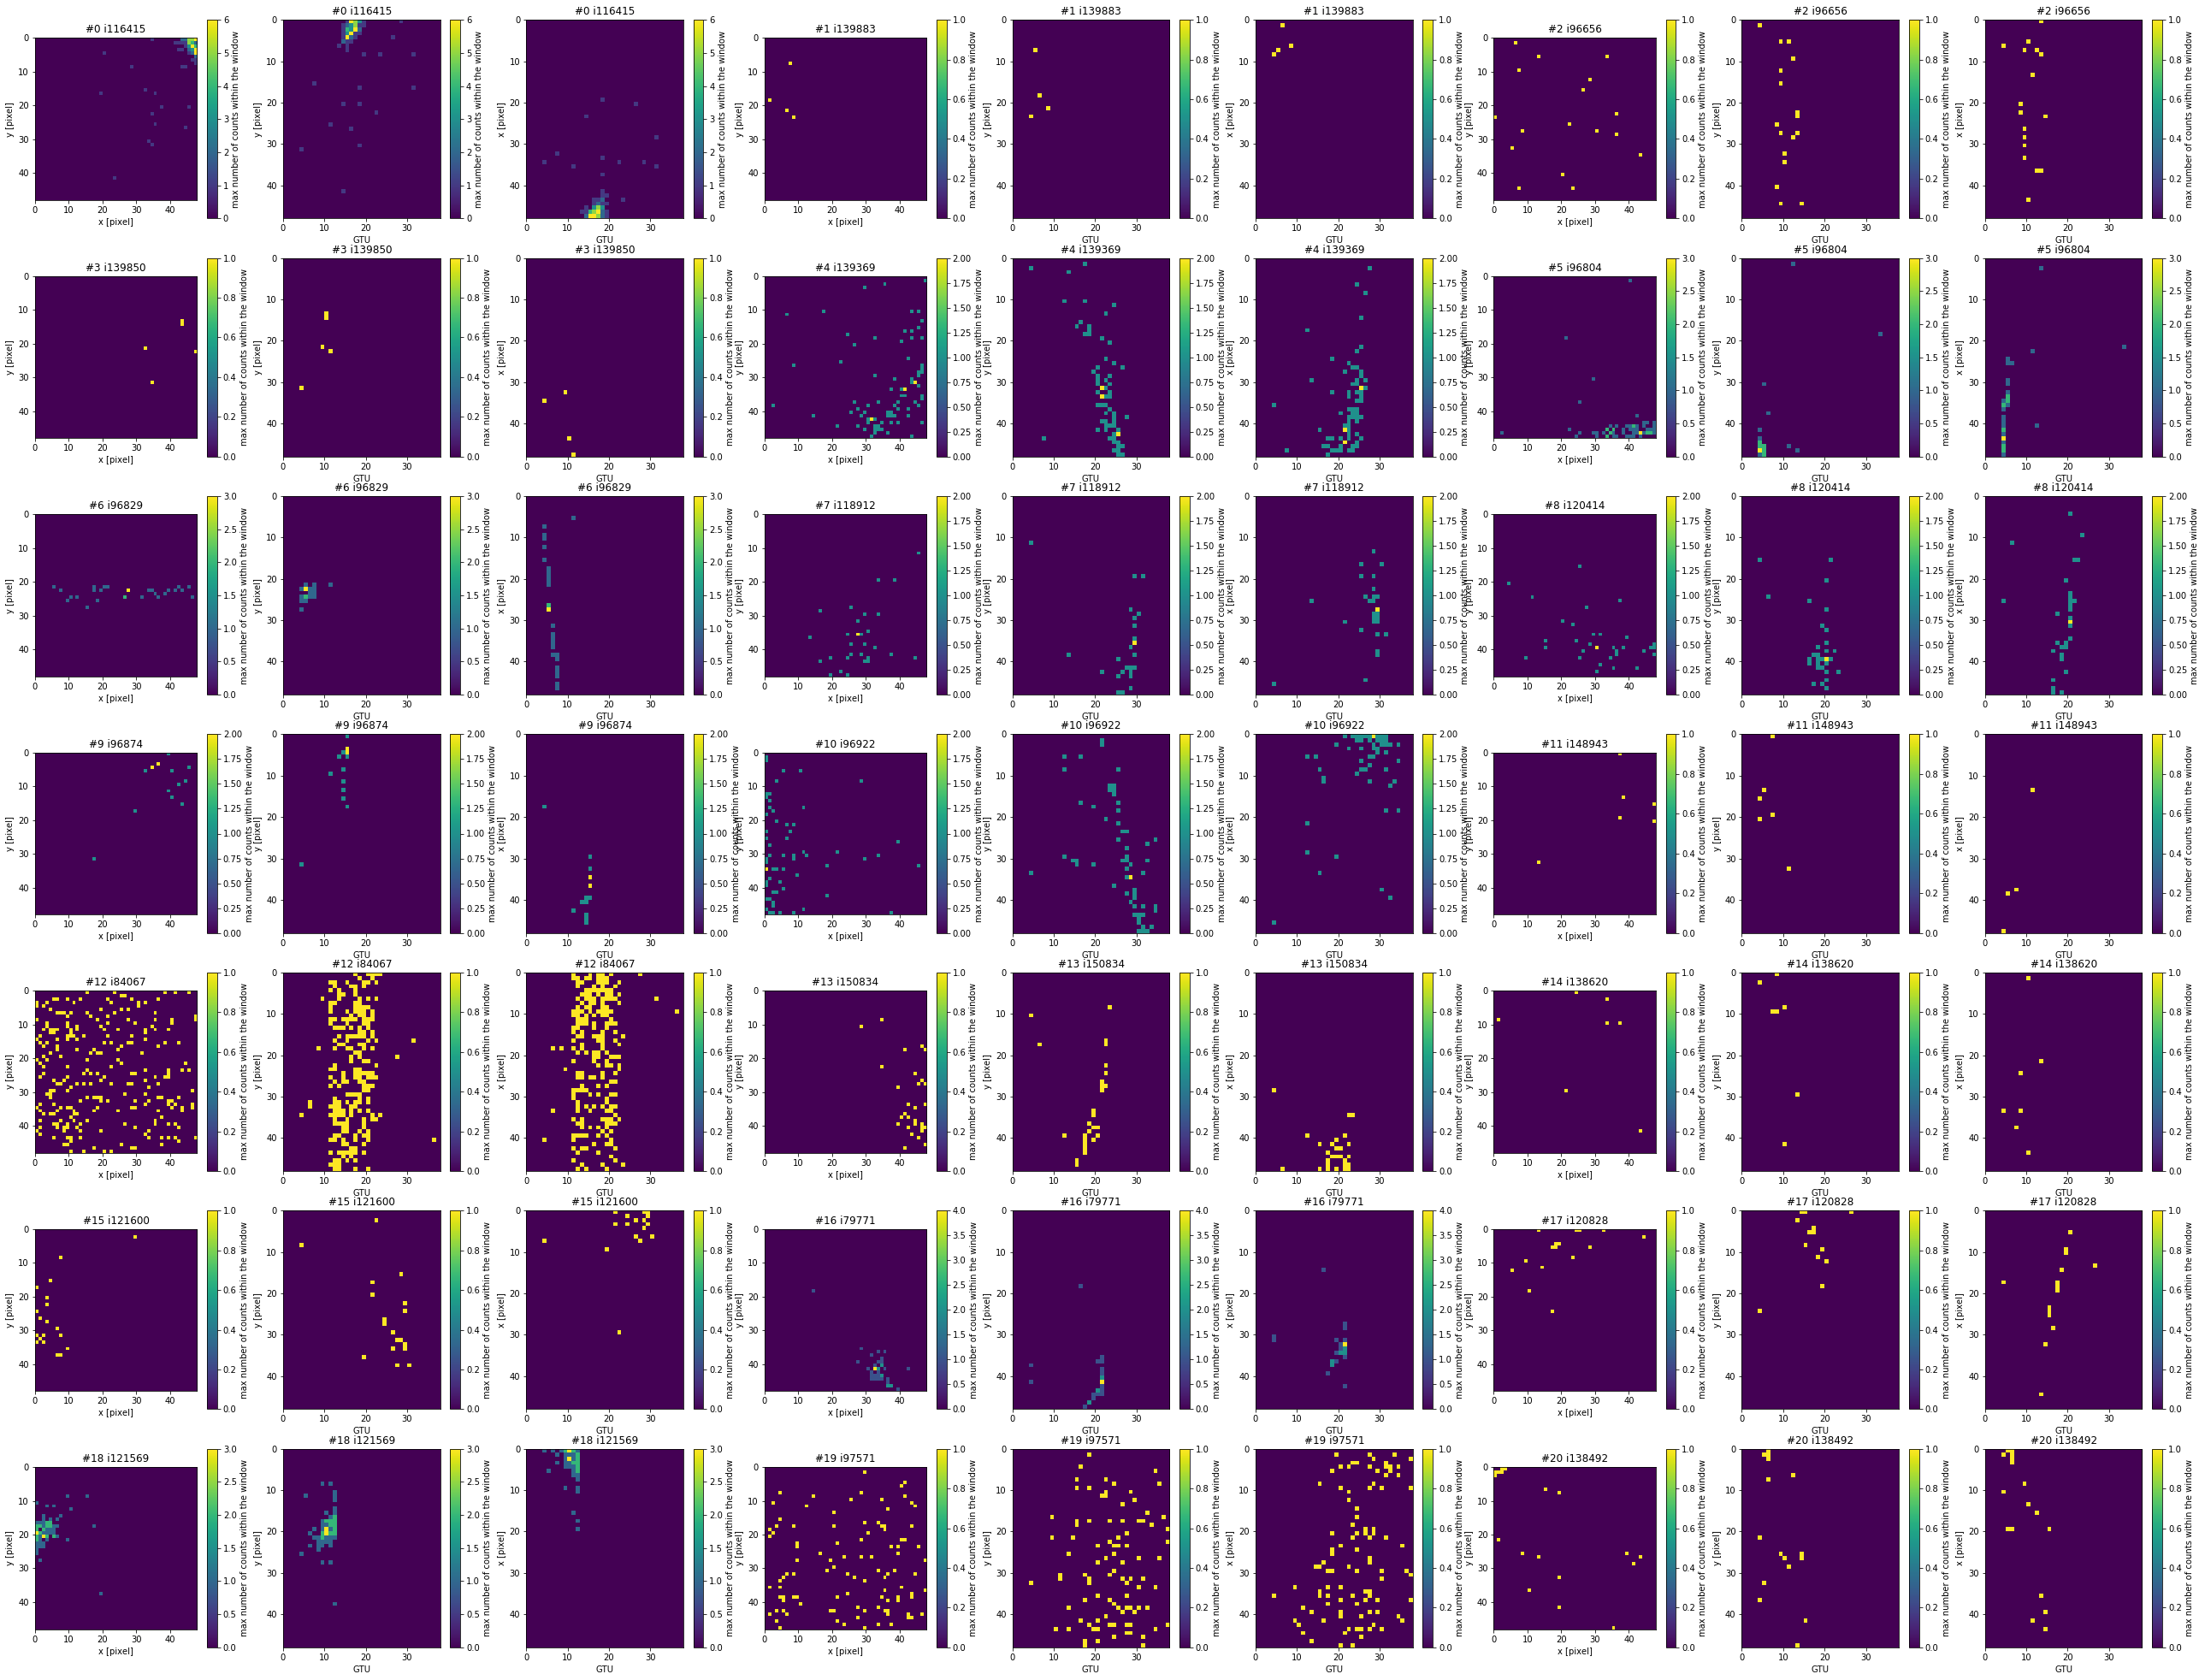

In [35]:
plt.close('all')

fig, axs = plt.subplots(7, 9)
fig.set_size_inches(9*5,7*5)
axs_flattened = axs.flatten()
ai = 0

for i,(rid,r) in enumerate(events_to_vis_df.iterrows()):
    simu_gtu_start = r['gtu_in_packet']-4-30
    simu_gtu_end = simu_gtu_start+r['num_gtu']
    
    if ai+2 >= len(axs_flattened):
        break

    visualize_simu_event_projections(r['source_file_acquisition_full'], 
                                     title="#{} i{}".format(i, r['event_id']), 
                                     axs_flattened=axs_flattened, 
                                     vis_xy=True, vis_gtux=True, vis_gtuy=True, ai=ai,
                                     gtu_range=(simu_gtu_start, simu_gtu_end),
                                     get_simunpy_func=lambda x:x)
    ai += 3
    
    if ai >= len(axs_flattened):
        break

    
plt.show()